In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import seaborn as sns
import tensorflow as tf

In [2]:
dimension=256
half_dim=int(dimension/2)
wdw=int(dimension/4)
wdwdw=int(dimension/4*3)

In [3]:
def leaky_relu(inp, alpha=0.2):
    return tf.maximum(inp * alpha, inp)

In [4]:
data_directory='/home/ubuntu/Data/'

In [17]:
img=plt.imread(data_directory+'Example.tif')
img=sp.misc.imresize(img, [dimension,dimension])
img=img/np.std(img)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


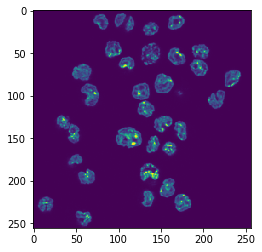

In [18]:
plt.imshow(img)

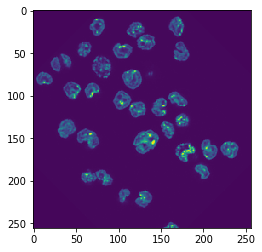

In [19]:
plt.imshow(sp.ndimage.rotate(img, 45, reshape=False))

In [20]:
def generate_batch(batch_size, rotation_range, shifting_range):
    rotates=np.random.uniform(-rotation_range,rotation_range, size=batch_size)
    shifts=np.random.uniform(-shifting_range,shifting_range, size=[batch_size,2])

    truth=np.stack([rotates, shifts[:,0], shifts[:,1]], axis=1)
    dat=np.stack([sp.ndimage.rotate(sp.ndimage.shift(img, truth[n,1:3]), truth[n,0], reshape=False ) for n in range(0,batch_size)])

    truth[:,0]=truth[:,0]
    truth[:,1:3]=truth[:,1:3]
    data=np.ndarray([batch_size,dimension,dimension,2])
    data[:,:,:,0]=dat
    data[:,:,:,1]=img
    data=data[:,wdw:wdwdw, wdw:wdwdw,:]
    return (data, truth)

In [36]:
remake=True

training_data=0
training_truth=0
if remake:
    training_data, training_truth=generate_batch(10000,180,50)
    np.save(data_directory+'training_data', training_data)
    np.save(data_directory+'training_truth', training_truth)
else:
    training_data=np.load(data_directory+'training_data.npy')
    training_truth=np.load(data_directory+'training_truth.npy')

In [37]:
validation_data,validation_truth=generate_batch(100,180,50)

In [38]:
tf.reset_default_graph()
#Input and output
x=tf.placeholder(dtype=tf.float32, shape=[None, half_dim,half_dim,2])
y=tf.placeholder(dtype=tf.float32, shape=[None,3])

lr=tf.placeholder(dtype=tf.float32, shape=[], name='learning_rate')

xr=x
yr=y

base_scaler=16

A1=leaky_relu(tf.layers.conv2d(xr, base_scaler, [3,3], padding='SAME', dilation_rate=1))
A1a=leaky_relu(tf.layers.conv2d(A1, base_scaler, [3,3], padding='SAME', dilation_rate=1))
A2=leaky_relu(tf.layers.conv2d(A1a, base_scaler, [3,3], padding='SAME', dilation_rate=2))
A2a=leaky_relu(tf.layers.conv2d(A2, base_scaler, [3,3], padding='SAME', dilation_rate=2))
A3=leaky_relu(tf.layers.conv2d(A2a, base_scaler, [3,3], padding='SAME', dilation_rate=3))
A4=leaky_relu(tf.layers.conv2d(A3, base_scaler, [3,3], padding='SAME', dilation_rate=4))
A5=leaky_relu(tf.layers.conv2d(A4, base_scaler, [3,1], padding='SAME', dilation_rate=5))
A6=leaky_relu(tf.layers.conv2d(A5, base_scaler, [3,1], padding='SAME', dilation_rate=6))

#Going down
B0=tf.nn.max_pool(A6, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
B1=leaky_relu(tf.layers.conv2d(B0, 2*base_scaler, [3,3], padding='SAME'))
B2=leaky_relu(tf.layers.conv2d(B1, 2*base_scaler, [3,3], padding='SAME'))

C0=tf.nn.max_pool(B2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
C1=leaky_relu(tf.layers.conv2d(C0, 4*base_scaler, [3,3], padding='SAME'))
C2=leaky_relu(tf.layers.conv2d(C1, 4*base_scaler, [3,3], padding='SAME'))

D0=tf.nn.max_pool(C2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
D1=leaky_relu(tf.layers.conv2d(D0, 8*base_scaler, [3,3], padding='SAME'))
D2=leaky_relu(tf.layers.conv2d(D1, 8*base_scaler, [3,3], padding='SAME'))

E0=tf.nn.max_pool(D2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
E1=leaky_relu(tf.layers.conv2d(E0, 16*base_scaler, [3,3], padding='SAME'))
E2=leaky_relu(tf.layers.conv2d(E1, 16*base_scaler, [3,3], padding='SAME'))

F0=tf.nn.max_pool(E2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
F1=leaky_relu(tf.layers.conv2d(F0, 16*base_scaler, [3,3], padding='SAME'))
F2=leaky_relu(tf.layers.conv2d(F1, 16*base_scaler, [3,3], padding='SAME'))

G0=tf.nn.max_pool(F2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
G1=leaky_relu(tf.layers.conv2d(G0, 16*base_scaler, [3,3], padding='SAME'))
G2=leaky_relu(tf.layers.conv2d(G1, 16*base_scaler, [3,3], padding='SAME'))

Flat=tf.layers.flatten(C2)

dense1=tf.layers.dense(Flat, units=1024)
dense2=tf.layers.dense(dense1, units=64)
logits=(tf.layers.dense(dense2, units=3))

diff=tf.subtract(yr,logits)
LSQ=tf.multiply(diff,diff)
loss=tf.reduce_mean(LSQ)
train_op=tf.train.AdamOptimizer(learning_rate=lr).minimize(loss)

In [42]:
tf.set_random_seed(123456)
sess=tf.Session()
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver(max_to_keep=50)
for f in range(0,5000):
    idx=np.random.choice(training_data.shape[0], replace=False, size=[40])
    cur_train=training_data[idx,:,:,:]
    cur_truth=training_truth[idx,:]
    _,results, losses=sess.run([train_op, logits, loss], feed_dict={x:cur_train, y:cur_truth, lr:0.001})
    if (f%100==0):
        res, valid_loss=sess.run([logits,loss], feed_dict={x:validation_data, y:validation_truth})
        print([f,losses, valid_loss])
        saver.save(sess, data_directory+'NewModels/Model'+str(f))
    

[0, 3544.7861, 4334.916]
[100, 3742.4026, 4034.6628]
[200, 1906.3613, 2142.2483]
[300, 1683.9148, 1256.3148]
[400, 792.5515, 951.1825]
[500, 601.9535, 740.9279]
[600, 713.96265, 544.5691]
[700, 482.09763, 414.0802]
[800, 240.06023, 515.7438]
[900, 307.7802, 390.3749]
[1000, 369.4316, 525.5951]
[1100, 471.6867, 310.03778]
[1200, 206.84764, 306.65805]
[1300, 171.47382, 224.8494]
[1400, 141.78023, 345.4282]
[1500, 310.52362, 193.98701]
[1600, 122.36286, 121.19614]
[1700, 181.85188, 257.4907]
[1800, 103.78368, 121.383514]
[1900, 104.25316, 214.92844]
[2000, 82.52006, 168.21622]
[2100, 93.058685, 243.91502]
[2200, 88.94393, 211.06673]
[2300, 91.22825, 132.95497]
[2400, 96.04068, 158.52467]
[2500, 63.281254, 86.17315]
[2600, 91.32091, 162.46532]
[2700, 294.73645, 167.90839]
[2800, 98.079056, 149.06004]
[2900, 46.3128, 170.38504]
[3000, 154.48349, 118.59535]
[3100, 88.197365, 168.60902]
[3200, 67.441246, 152.96036]
[3300, 56.41517, 117.5425]
[3400, 37.20838, 112.806366]
[3500, 144.1431, 110.4

KeyboardInterrupt: 

In [43]:
res, valid_loss=sess.run([logits,loss], feed_dict={x:validation_data, y:validation_truth})

In [52]:
idx=np.random.randint(0,100)
print(idx)
print(res[idx,:])
print(validation_truth[idx,:])

26
[-104.790146   42.04472    42.314995]
[-127.96739047   46.01618485   48.00432569]
